# Mozafari Deep Tutorial with MNIST

The purpose of this tutorial is to show the state of the network at each layer to help understand the inner workings of this spiking neural network. Several examples are provided in the accompanying publication, however, they were not specific to MNIST. This tutorial is inferrence only with the network set for eval() mode and required a previously trained model to run correctly. Such a model has been committed to the MozafariDeep folder and was tested to a 97.6 % accuracy.

A single image is selected from the MNIST test dataset. This tutorial then shows state of each layer, including layer dimensions and feature maps, as the layer is processed. The following is a diagram of the Mozafari Deep Spiking Neural Network utilized in this tutorial.  Additional instrumentation has been added to MozafariDeep to stop the simulation and return the spike wave following each layer based upon a specified max_layer paramenter. This returned value is what is presented in each section.

The following sections are aligned with the layers in this diagram.

<img src="./images/mozafari-net.png" alt="Diagram of the Mozafari SDNN" width="1000"/>

## Layer 1: Intensity to Latency Encoding

This section includes the code for the 6 Difference of Gausian (DoG) filters as well as the code to load the MNIST Test data set and load a single sample from it.

In [1]:
from SpykeTorch import utils
from torchvision import transforms
from MozafariDeep import *

kernels = [ utils.DoGKernel(window_size=3,sigma1=3/9,sigma2=6/9),
            utils.DoGKernel(window_size=3,sigma1=6/9,sigma2=3/9),
            utils.DoGKernel(window_size=7,sigma1=7/9,sigma2=14/9),
            utils.DoGKernel(window_size=7,sigma1=14/9,sigma2=7/9),
            utils.DoGKernel(window_size=13,sigma1=13/9,sigma2=26/9),
            utils.DoGKernel(window_size=13,sigma1=26/9,sigma2=13/9)]
filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)

In [2]:
#
# Load the MNIST datasets, apply the s1c1 transformation filter as the data sets are loaded and 
#    leverage the CacheDataset wrapper to improve performance.
#
data_root = "data"
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = s1c1))
MNIST_testLoader = DataLoader(MNIST_test, batch_size=len(MNIST_test), shuffle=False)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1, shuffle=True)

In [3]:
# Get a single batch from the DataLoader
dataiter = iter(MNIST_testLoader)
images, labels = next(dataiter)

0


### Dimensions of Layer 1
The shape of the tensor is described as follows:  

images[batch_size][time_step][feature][height][width]

In this case, there is a single image in the batch, so the size is 1. The Intensity to Latency encoding is performed over 15 time_steps. There are six separate DoG Kernels applied to the input images so this gives a total of 6 feature maps, each with the height and width of the original image, 28x28.

In [4]:
print(images.shape)

torch.Size([1, 15, 6, 28, 28])


### Visualization of Layer 1
The following charts show each of the feature maps across the 15 time steps.

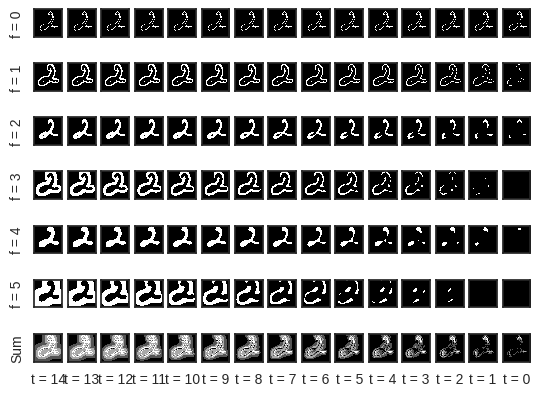

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-white')
plt_idx = 0
# For each feature (channel)
for f in range(6):
    # For each timestep
    for t in range(15):
        # image = images[0][t].permute(1,2,0)
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = images[0][t]
        plt_idx += 1
        ax = plt.subplot(7, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 5:
            ax = plt.subplot(7, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

## Network Initialization
This section initializes the network, makes certain that CUDA is available and then loads the previously trained SNN.

In [6]:
#
# Initialize the network
#
mozafari = MozafariMNIST2018()

In [7]:
#
# Setup CUDA
#
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    if use_cuda:
        print("Activating CUDA on network")
        mozafari.cuda()
else:
    print("CUDA is not available")

NVIDIA GeForce GTX 1650 SUPER
Activating CUDA on network


In [8]:
print("DoG Image Spikewave transferred to CUDA")
dog_spike_wave = images.cuda()

DoG Image Spikewave transferred to CUDA


In [9]:
print("Load the fully trained Mozafari Deep SNN")
if os.path.isfile("MozafariDeep/saved.net"):
    mozafari.load_state_dict(torch.load(f="saved.net",weights_only=False))
    mozafari.eval()
else:
    print("Pre-trained network is not available for first convolutional layer.")



Load the fully trained Mozafari Deep SNN


## Layer 2 Convolutional Layer (S1)
Apply the first convolutional layer (S1) to the incoming DoG Spike Wave

In [10]:
#
# Process The First Convolutional Layer
#

spike_wave,potentials = mozafari(dog_spike_wave[0],max_layer=Layer.Conv1)

### Dimensions of Layer 2 (S1)
The shape of the spike wave generated after Convolutional Layer (S1) is described as follows:  

spike_wave[time_step][feature][height][width]

There are still 15 time steps, however the number of feature layers that have been previously trained (using STDP) is 30. The height and width are the same as the input images at 28x28. Each of the six input channels are processed by S1 and spikes are generated in the output as specifically trained features are detected.

In [11]:
print(spike_wave.shape)

torch.Size([15, 30, 28, 28])


### Visualization of Layer 2 (S1)

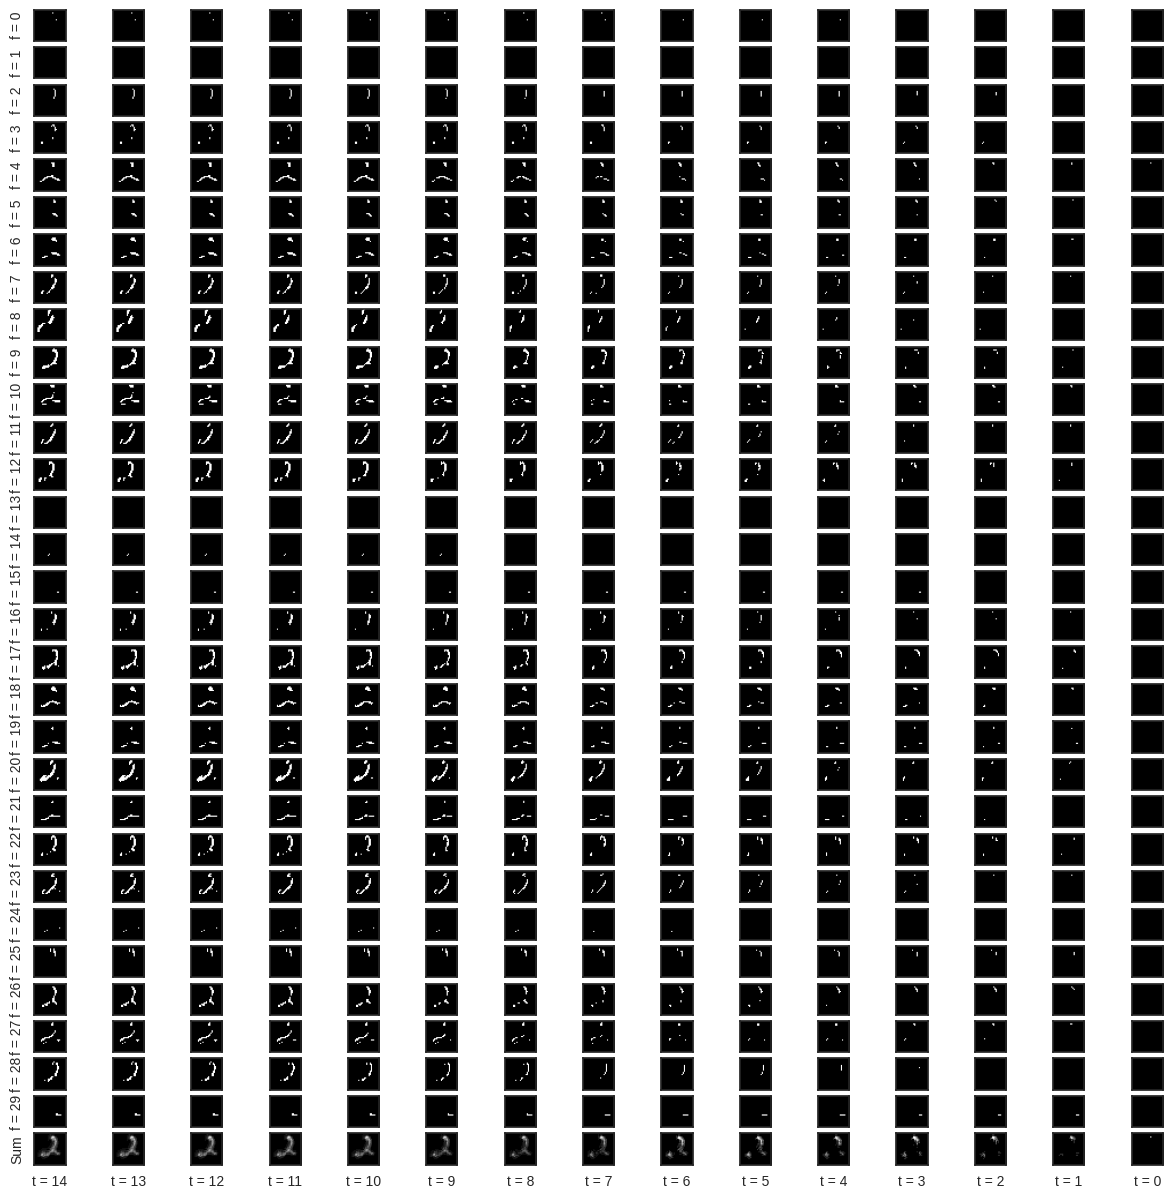

In [12]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,15)
plt_idx = 0
# For each feature (channel)
display_wave = spike_wave.cpu()
for f in range(30):
    # For each timestep
    for t in range(15):
        # image = images[0][t].permute(1,2,0)
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(31, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 29:
            ax = plt.subplot(31, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

## Layer 3: Pooling Layer (C1)

In [13]:
#
# Process The First Pooling Layer
#

spike_wave = mozafari(dog_spike_wave[0],max_layer=Layer.Pool1)


### Dimensions of Layer 3 (C1)
The timesteps and number of features remain the same as Layer 2, however the resolution of each feature has been reduced from 28x28 to 16x16 with padding.s

In [14]:
print(spike_wave.shape)

torch.Size([15, 30, 16, 16])


### Visualization of Layer 3 (C1)

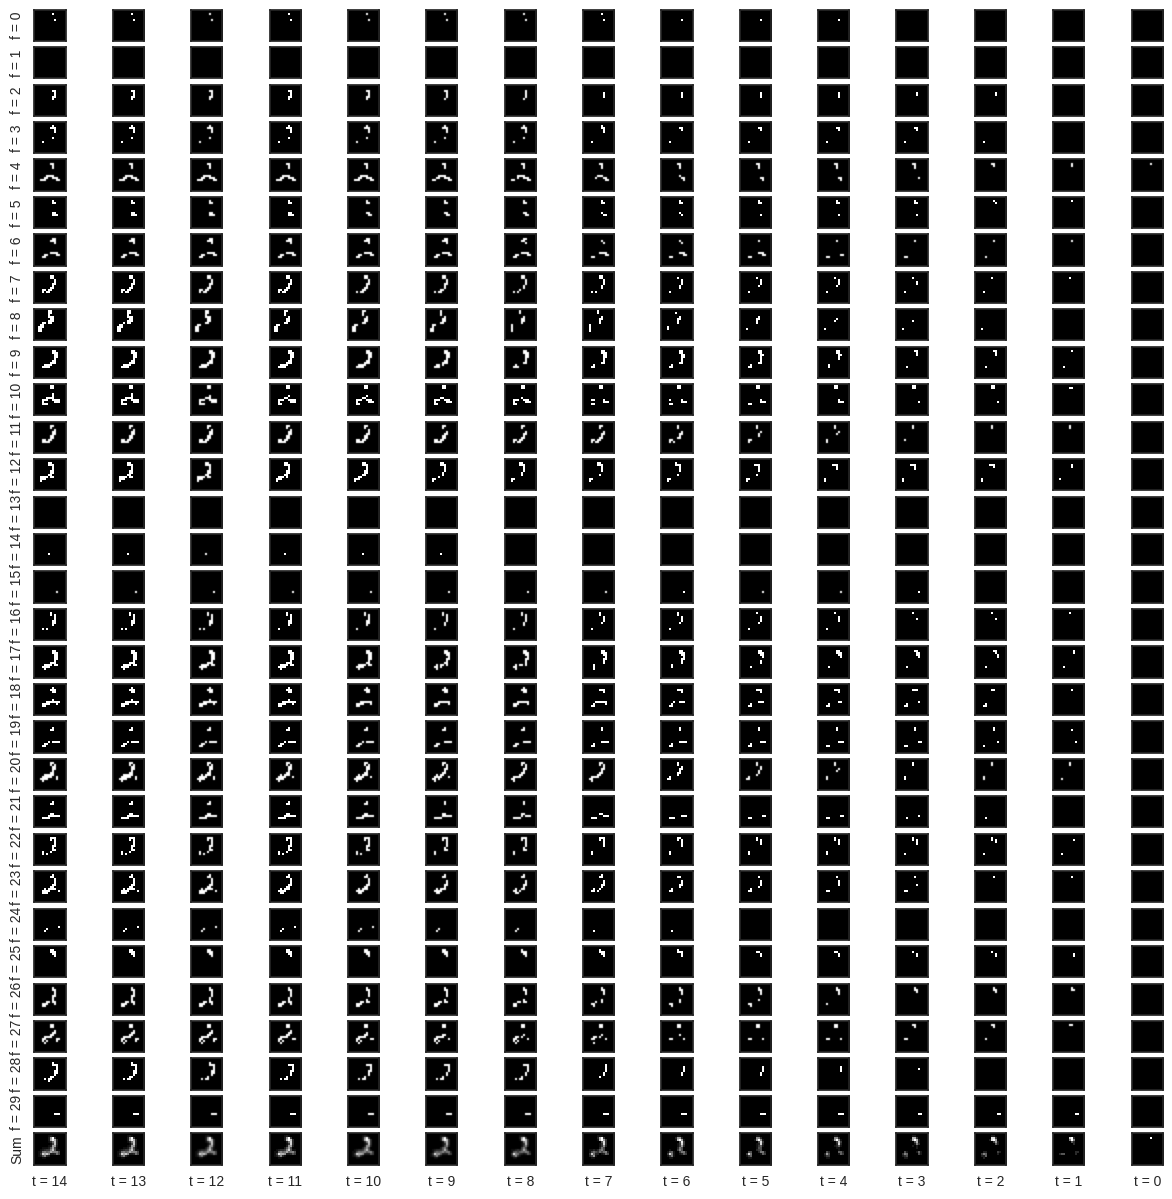

In [15]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,15)
plt_idx = 0
# For each feature (channel)
display_wave = spike_wave.cpu()
for f in range(30):
    # For each timestep
    for t in range(15):
        # image = images[0][t].permute(1,2,0)
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(31, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 29:
            ax = plt.subplot(31, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

## Layer 4: Convolutional Layer (S2)

In [16]:
#
# Process The Second Convolutional Layer
#

spike_wave,potentials = mozafari(dog_spike_wave[0],max_layer=Layer.Conv2)


### Dimensions of Layer 4 (S2)

The number of feature maps in Layer 4 is increase to 250 and the height and width of each feature map is the same as the preceeding pooling layer before the padding.  

spike_wave[time_step][feature][height][width]

In [17]:
print(spike_wave.shape)

torch.Size([15, 250, 14, 14])


### Visualization of Layer 4 (S2)

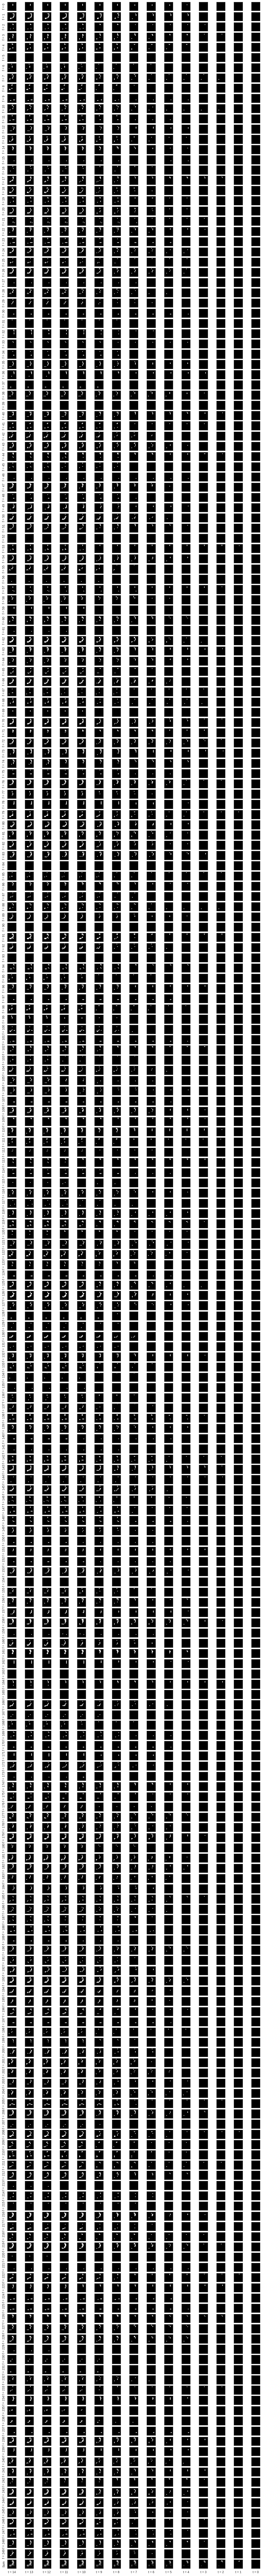

In [18]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,150)
plt_idx = 0
# For each feature (channel)
display_wave = spike_wave.cpu()
for f in range(250):
    # For each timestep
    for t in range(15):
        # image = images[0][t].permute(1,2,0)
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(251, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 249:
            ax = plt.subplot(251, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

## Layer 5: Pooling Layer (C2)

In [19]:
#
# Process The Second Pooling Layer
#

spike_wave = mozafari(dog_spike_wave[0],max_layer=Layer.Pool2)


### Dimensions of Layer 5 (C2)
Again, the pooling layer has the same number of time steps and features as the preceeding convolutional layer, however the height and width of each feature have been further reduced to 8x8 after padding. The padding on this pooling layer is (2,2,2,2) whereas the previous pooling layer had a padding of (1,1,1,1)

In [20]:
print(spike_wave.shape)

torch.Size([15, 250, 8, 8])


### Visualization of Layer 5 (C2)

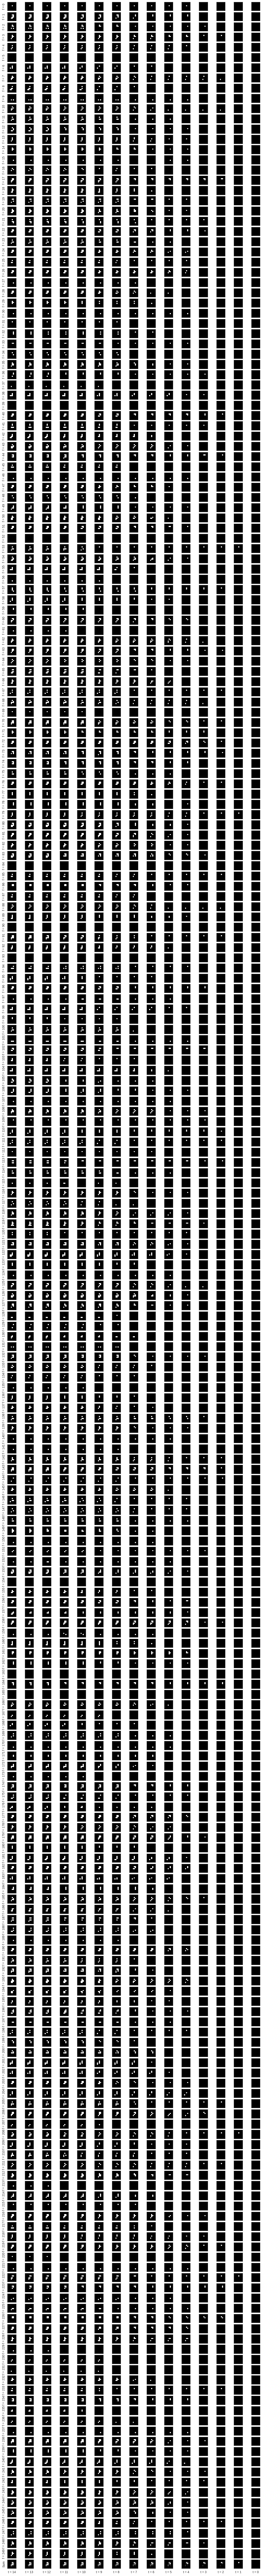

In [21]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,150)
plt_idx = 0
# For each feature (channel)
display_wave = spike_wave.cpu()
for f in range(250):
    # For each timestep
    for t in range(15):
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(251, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 249:
            ax = plt.subplot(251, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

## Layer 6: Convolutional Layer (S3)

In [22]:
#
# Process The Third Convolutional Layer
#

potential_wave = mozafari(dog_spike_wave[0],max_layer=Layer.Conv3)


### Dimensions of Layer 6 (S3)
This convolutation layer applies 200 trained feature maps to the output from the previous pooling layer (C2). The height and width align with the unpadded output from that pooling layer. 

potential_wave[time_step][feature][height][width]

In [23]:
print(potential_wave.shape)

torch.Size([15, 200, 4, 4])


### Visualizing Layer 6 (S3)
Convolutional S3 does not apply any thresholding to the neurons, allowing the neurons to accumulate the maximum potential possible. This is used as the first part of the global pooling mechanism described in the paper. In order to visualize this, we added a (1,1,1,1) padding around each feature map to set them apart. In addition, we are using a color to visualize the relative strength of the neuron potential within each feature map.  

NOTE:  The color ranges are currently auto scaled and I need to confirm that a consistent scale is used across all feature maps, not within each individual feature map.

In [24]:
conv3_spike_wave = sf.pad(potential_wave, (1,1,1,1))
display_wave = conv3_spike_wave.cpu()

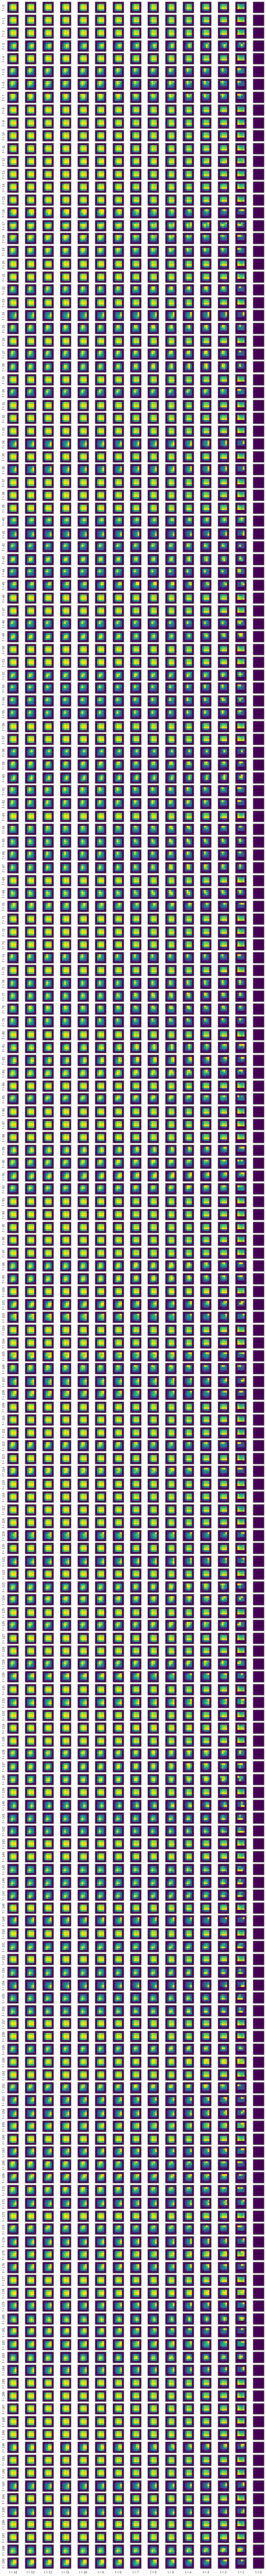

In [25]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,150)
plt_idx = 0
# For each feature (channel)
# display_wave = spike_wave.cpu()
for f in range(200):
    # For each timestep
    for t in range(15):
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(201, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel("f = " + str(f))
            
        plt.imshow(image[f],cmap='viridis')

        if f == 199:
            ax.set_xlabel('t = ' + str(t))
plt.show()

## Global Pooling Layer
This is the layer that performs the final decision making. It uses a k_winner algorithm to determing the feature with the earliest spike with the highest potential. This then indexes into a decision array to identify the correct value.

In [26]:
#
# Process The Global Max Pooling Layer ( k_winner )
#

winner = mozafari(dog_spike_wave[0],max_layer=Layer.Winner)
print("The winner is: " + str(winner[0][0]))

The winner is: 58


In [27]:
#
# Processing the full Mozafari network
#
decision = mozafari(dog_spike_wave[0],max_layer=Layer.Full)

print("The Mozafari network classified the input as: " + str(decision))
print("The labelled value for this image is: " + str(labels[0].item()))

The Mozafari network classified the input as: 2
The labelled value for this image is: 2
